## analyse train soundscape 

- Resample it to 44100
- save resampled wav file
- crete a 10 sec chunk
- save the melspec for 10 sec chunk

In [1]:
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm
import cv2
from joblib import delayed,Parallel
import pandas as pd

## first convert ogg to wav with samplerate of 44100

In [2]:
train_sound = os.listdir('../data/train_soundscapes/')
print(train_sound[:5])

['50878_COR_20191004.ogg', '54955_SSW_20170617.ogg', '31928_COR_20191004.ogg', '21767_COR_20190904.ogg', '26746_COR_20191004.ogg']


In [3]:
## just a check
y, sr = librosa.load('../data/ff1010bird/audio/wav/100.wav', sr = None)
print(sr)

y, sr = librosa.load('../data/train_soundscapes/11254_COR_20190904.ogg', sr = None)
print(sr)

44100
32000


In [4]:
train_sound[0].split('.')[0]

'50878_COR_20191004'

In [10]:
Target_sr = 44100

def resample_to_wav(x):
    y, original_sr = librosa.load(f'../data/train_soundscapes/{x}', sr = None)
    resample_y = librosa.resample(y, orig_sr=original_sr, target_sr=Target_sr)
    f_name = x.split('.')[0]
    #librosa.output.write_wav(f'../data/train_soundscapes/{f_name}.wav', resample_y, Target_sr,) 
    sf.write(f'../data/train_soundscapes/{f_name}.wav', resample_y, Target_sr)



_ = Parallel(n_jobs=-1, verbose=1)(
    delayed(resample_to_wav)(
    file,
    ) for file in train_sound#[:5]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   25.9s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   26.2s finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## now we only have wav files after deleting the ogg files

## lets create melspec for 10 sec interval



In [39]:
filename = os.listdir('../data/train_soundscapes/')[0].split('.')[0].split('_')
f'{filename[0]}_{filename[1]}'+f'_sec_{0+10}'

'44957_COR_sec_10'

In [40]:
DATASET_TYPE = 'train_soundscapes'

IMAGE_SHAPE = 512
n_fft = 1024
hop_length = 512
n_mels = 128
NewMax = 255.
NewMin = 0.

train_sound = os.listdir('../data/train_soundscapes/')

def image_creation(file,):
    
    y, sr = librosa.load(f'../data/train_soundscapes/{file}', sr = None)
    
    for i in tqdm(range(0, int(len(y)/44100), 10)):
        S = librosa.feature.melspectrogram(y[i*sr:(i+10)*sr], sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,win_length=None)
        S_DB = librosa.power_to_db(S, ref=np.max)
        S_DB = (((S_DB - S_DB.min()) * (NewMax - NewMin)) / (S_DB.max() - S_DB.min())) + NewMin
        S_DB = np.flipud(S_DB)
        image = np.dstack([S_DB,S_DB,S_DB])
        image = image.astype(np.uint8)
        filename = file.split('.')[0].split('_')
        filename = f'{filename[0]}_{filename[1]}'+f'_sec_{i+10}'
        image = cv2.resize(image,[IMAGE_SHAPE, IMAGE_SHAPE])
        cv2.imwrite(f'../data/{DATASET_TYPE}_melspec/{filename}.jpg',image)
    
Parallel(n_jobs=-1, verbose=1)(
    delayed(image_creation)(
    file,
    ) for file in train_sound#[:2]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
  2%|▏         | 1/60 [00:00<00:32,  1.84it/s]/tmp/ipykernel_462/3368533749.py:17: FutureWarning: Pass y=[ 0.05249023  0.05249023  0.05154419 ... -0.08779907 -0.06591797
 -0.05657959] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/tmp/ipykernel_462/3368533749.py:17: FutureWarning: Pass y=[-0.06503296 -0.0748291  -0.0838623  ... -0.04721069 -0.04089355
 -0.03704834] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/tmp/ipykernel_462/3368533749.py:17: FutureWarning: Pass y=[-0.03457642 -0.03582764 -0.04199219 ... -0.01620483 -0.01739502
 -0.02142334] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/tmp/ipykernel_462/3368533749.py:17: FutureWarning: Pass y=[-0.02679443 -0.03125    -0.03353882 ...  0.00714111  0.01651001
  0.01773071] as keyword args. From version 0.10

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## lets transform the train_soundscape csv first

In [28]:
main_df = pd.read_csv('../data/train_soundscape_labels.csv')

def bird_to_idx(x):
    if x =='nocall':
        return 0
    else:
        return 1
    
def audio_file_id(x):
    v = x.split('_')
    return f'{v[0]}_{v[1]}'
    
main_df['audio_file_id'] = main_df['row_id'].map(audio_file_id)
main_df['bird_idx'] = main_df['birds'].map(bird_to_idx)
#main_df.head()

by = 2
win = 2
start = 1 ## it is the index of your 1st valid value.
main_df = main_df.groupby('audio_file_id').rolling(win).max()[start::by].reset_index()

main_df = main_df.drop(['level_1'],axis=1)

main_df.rename(columns={'seconds':'seconds_end'},inplace=True)

main_df['fold'] = main_df.index%10


def file_name(audio_file_id, seconds_end):
    return f'{audio_file_id}_sec_{int(seconds_end)}'

main_df['filename'] = main_df.apply(lambda x: file_name(audio_file_id = x['audio_file_id'], seconds_end = x['seconds_end']), axis=1)


main_df.to_csv('../data/train_soundscape_labels_10_sec.csv',index=False)

/tmp/ipykernel_1138/138701980.py:20: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['birds', 'row_id', 'site'], dtype='object')
  main_df = main_df.groupby('audio_file_id').rolling(win).max()[start::by].reset_index()


In [29]:
main_df.head()

,audio_file_id,audio_id,seconds_end,bird_idx,fold,filename
0,10534_SSW,10534.0,10.0,1.0,0,10534_SSW_sec_10
1,10534_SSW,10534.0,20.0,0.0,1,10534_SSW_sec_20
2,10534_SSW,10534.0,30.0,1.0,2,10534_SSW_sec_30
3,10534_SSW,10534.0,40.0,0.0,3,10534_SSW_sec_40
4,10534_SSW,10534.0,50.0,1.0,4,10534_SSW_sec_50


In [21]:
main_df[['audio_file_id','seconds_end']]

audio_file_id    10534_SSW
seconds_end           10.0
dtype: object

## now create TF record

In [30]:
import os, json, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf, re, math
from tqdm import tqdm

In [31]:
main_df = pd.read_csv('../data/train_soundscape_labels_10_sec.csv')
main_df.head()

,audio_file_id,audio_id,seconds_end,bird_idx,fold,filename
0,10534_SSW,10534.0,10.0,1.0,0,10534_SSW_sec_10
1,10534_SSW,10534.0,20.0,0.0,1,10534_SSW_sec_20
2,10534_SSW,10534.0,30.0,1.0,2,10534_SSW_sec_30
3,10534_SSW,10534.0,40.0,0.0,3,10534_SSW_sec_40
4,10534_SSW,10534.0,50.0,1.0,4,10534_SSW_sec_50


In [32]:
def get_fold(fold):
    val_df = main_df[main_df.fold==fold].reset_index(drop=True)
    return val_df

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image,image_name,target):
    feature = {
        'image': _bytes_feature(image),
        'image_name': _bytes_feature(image_name),
        'target': _int64_feature(target),

      }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [67]:
DATASET_TYPE = 'train_soundscapes'


def create_tf_records(fold = 0):
    df = get_fold(fold)
    tfr_filename = f'../data/tfrec/train_soundscapes_10sec/train-soundscape-{fold}-{df.shape[0]}.tfrec'
    with tf.io.TFRecordWriter(tfr_filename) as writer:
        for i,row in tqdm(df.iterrows()):
            itemid = row.filename
            end_sec = row.seconds_end
            target = row.bird_idx
            
            #file = f'{itemid}_sec_{end_sec}'
            #'../data/{DATASET_TYPE}_melspec/
            image_path = f"../data/train_soundscapes_melspec/{itemid}.jpg"
            
            image = tf.io.read_file(image_path)
            #audio, sample_rate = tf.audio.decode_wav(audio,
            #                                 desired_channels=-1,
            #                                 desired_samples=-1)
            image_name = str.encode(str(itemid))
            example = serialize_example(image,image_name,int(target))
            writer.write(example)

In [68]:
for i in range(10):
    create_tf_records(fold = i)

120it [00:00, 3589.25it/s]
120it [00:00, 3690.11it/s]
120it [00:00, 3576.82it/s]
120it [00:00, 4190.88it/s]
120it [00:00, 3994.48it/s]
120it [00:00, 4202.64it/s]
120it [00:00, 4196.40it/s]
120it [00:00, 3822.33it/s]
120it [00:00, 3979.67it/s]
120it [00:00, 3897.06it/s]


## lets vizualize

In [59]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.image.resize(image,IMAGE_SIZE_)
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        'target': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = example['target']
    return image, label # returns a dataset of (image, label) pairs

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [60]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0,1]

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
    #    numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def display_single_sample(image, label, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    title = str(label)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch):
    """
    Display single batch Of images 
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        correct = True
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_single_sample(image, label, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [55]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

10
1200


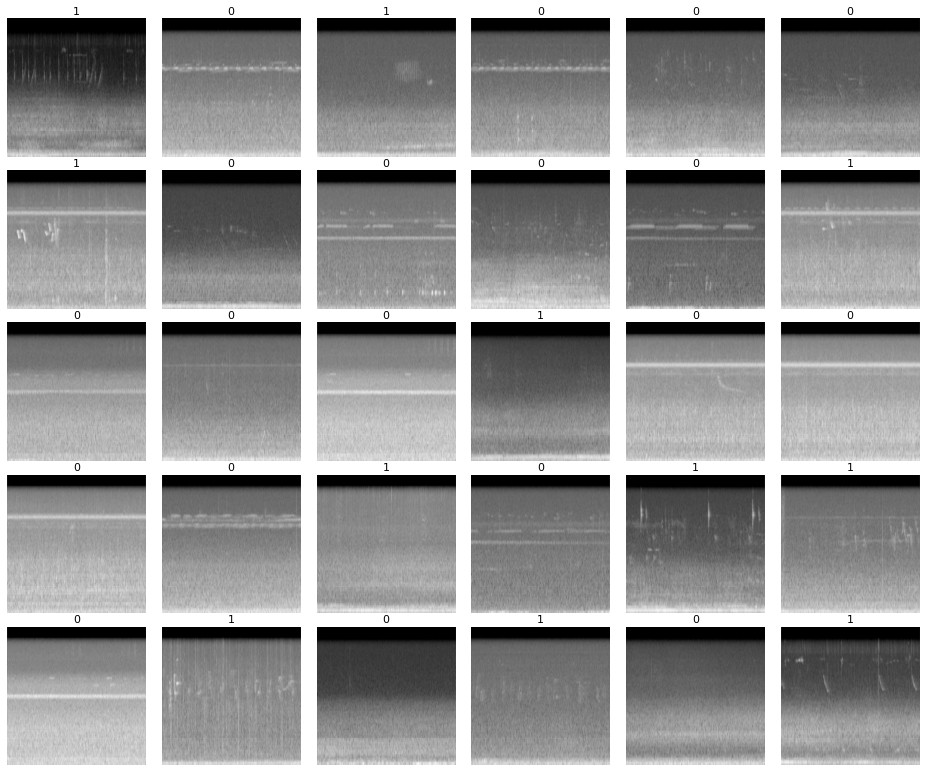

In [64]:
IMAGE_SIZE_ = [IMAGE_SIZE,IMAGE_SIZE]
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob(f'../data/tfrec/train_soundscapes_10sec/train-soundscape-*.tfrec')
print(len(TRAINING_FILENAMES))
dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
dataset = dataset.repeat()
dataset = dataset.shuffle(2048)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(AUTO) #This dataset can directly be passed to keras.fit method
print(count_data_items(TRAINING_FILENAMES))

# Displaying single batch of TFRecord
train_batch = iter(dataset)
display_batch_of_images(next(train_batch))